In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

%matplotlib inline

%load_ext watermark
%watermark -iv

seaborn 0.9.0
numpy   1.15.4
pandas  0.24.0



# Data load

Read the cleaned data from the load_clean notebook.

In [2]:
data = Path('../data/churn_cleaned.pkl')
assert(data.exists())

df = pd.read_pickle(data)

df.shape

(7043, 21)

# Exploratory Data Analysis

Let's start by breaking the columns into general categories

In [3]:
# Products, broken down by phone and internet products
phone_cols =  ['PhoneService', 'MultipleLines']
internet_cols =  ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                  'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies']
products =  phone_cols + internet_cols 

# customer categories, broken down by categorical and continuous variables
cust_cats = ['gender', 'SeniorCitizen', 'Partner', 'Dependents' ]
cust_cont =  [ 'MonthlyCharges', 'tenure', 'TotalCharges']
cust_cols = cust_cats + cust_cont

# billing categories
bill_cols = ['Contract','PaperlessBilling','PaymentMethod']


In [4]:
# Put all the plotting stuff in one place for all the plots below

def eda_cat_barchart( df, cols, title=None, group=None ):
    # split the customers into churn and no-churn groups
    no_churn = df.query('Churn == "No"')
    churn = df.query('Churn == "Yes"')

    # for each group, get the sum for each subcategory of products and 
    # divide by group size to get the fraction of customers in that
    # subcategory
    churn_counts = pd.get_dummies(churn[cols]).sum() / churn.shape[0] 
    churn_counts.name = 'Churn' 

    no_churn_counts = pd.get_dummies(no_churn[cols]).sum() / no_churn.shape[0]
    no_churn_counts.name = 'No Churn'
    
    if group != None:
        gen_pop_counts = pd.get_dummies(df[cols]).sum() / df.shape[0]
        gen_pop_counts.name = group
        data = [churn_counts, no_churn_counts, gen_pop_counts]
        columns = ['Product', 'Churn', 'No Churn', group ]
    else:
        data = [churn_counts, no_churn_counts ]
        columns = ['Product', 'Churn', 'No Churn' ] 
            
    # combine the above into one dataframe
    percent_churn = pd.DataFrame(data=data).T.reset_index()
    percent_churn.columns = columns

    # this turns the concatenated get_dummies names back into separate columns
    percent_churn['Category'] = percent_churn.Product.str.split('_').apply(lambda x:x[1])
    percent_churn['Product'] = percent_churn.Product.str.split('_').apply(lambda x:x[0])

    # The product and the category of choice on that product are the index of the new dataframe
    percent_churn = percent_churn.set_index(['Product', 'Category'])
    percent_churn = percent_churn.query('Churn != 0') # useful for subgroup plots to drop empty bars
    
    # plot all the fractions
    ax = (100 * percent_churn).plot.bar(figsize=(12,8))
    ax.set_ylabel('Percent')
    if title != None:
        ax.set_title(title)

## Is there a particular product that has greater churn? 

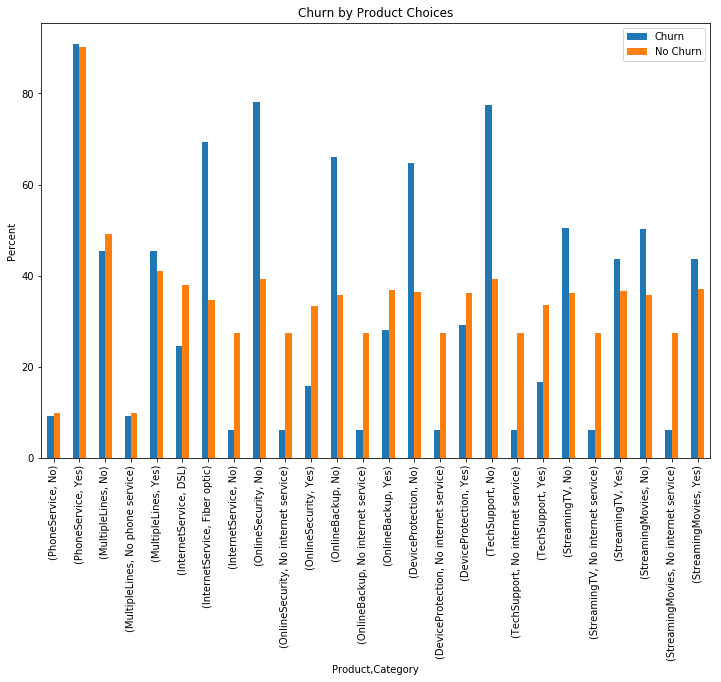

In [5]:
eda_cat_barchart(df, products, title='Churn by Product Choices')

The phone service choices look quite similar for the churn and no churn group. But, for internet service, the churned
customers have noticably different percent distributions from the non-churned population. 

The customers heading for the exits appear to be disproportionately likely:
- To have internet service in general, and more specifically fiber optic instead of DSL 
- Opted not to get Online Security, Online Backup, Device Protection, and Technical Support

The business should look to see if there are issues delivering quality fiber optic service to customers. Additionally, customers who don't churn are more likely to have Technical Support and other services purchased as 
insurance against problems. Perhaps the churned customers encountered problems and then found out that the
company was unresponsive or that the price quoted to diagnose and fix issues for customers without 
those services in their plans was too expensive.

Let's try to explore the internet business in greater detail.

## Internet Service in detail

Let's reproduce the above graph, but dropping out the phone-only customers and categories. 

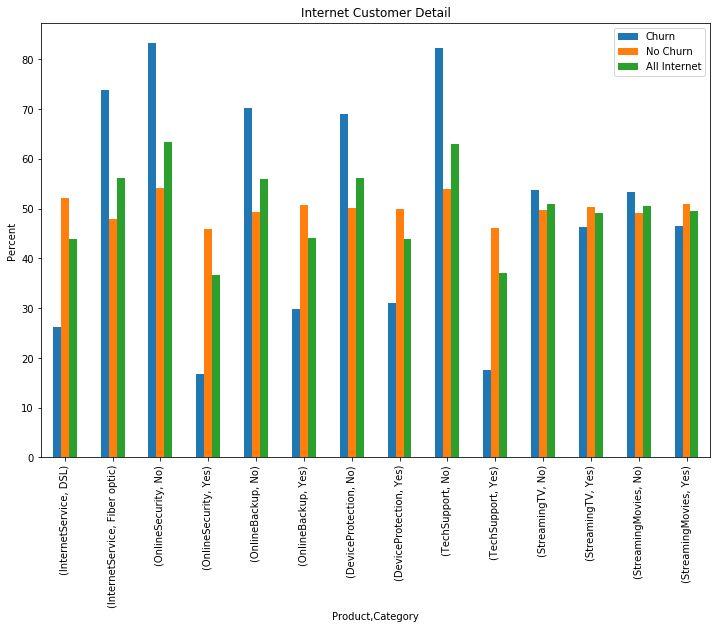

In [6]:
eda_cat_barchart(df.query('InternetService != "No"'), 
                 internet_cols, 
                 title='Internet Customer Detail',
                 group='All Internet')

With this detailed view, I'm not as concerned that churned customers are unhappy with streaming TV or movies: the
churn and no-churn customers appear to be making similar choices there. However, I continue to be concerned about 
the fiber optic subsegment and whether the churned customers possibly had problems with their service that were
not covered under their plans. Unfortunately, I do not have data as to whether a customer reported a 
technical issue or whether there was a fiber optic service outage in the month this data was collected. For a 
Kaggle dataset, you get what you get.

# Is there a particular customer segment that has greater churn? 

Unlike the service choice column sets, this time we have to deal with numerical columns. I'm going
to bin and turn them into categories. 

In [7]:
df.MonthlyCharges.describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [8]:
df.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [9]:
df.TotalCharges.describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

In [10]:
df[['tenure', 'TotalCharges']].corr()

,tenure,TotalCharges
tenure,1.000000,0.826178
TotalCharges,0.826178,1.000000


In [11]:
tenure_times_bill = df.eval('tenure * MonthlyCharges')
tenure_times_bill.name = 'tenure * MonthlyCharges'
pd.DataFrame(data=[tenure_times_bill, df.TotalCharges]).T.corr()

,tenure * MonthlyCharges,TotalCharges
tenure * MonthlyCharges,1.000000,0.999561
TotalCharges,0.999561,1.000000


TotalCharges is essentially tenure times MonthlyCharges.

In [12]:
df['tenureBin'] = pd.cut(df.tenure, bins=5)
df['MonthlyChargeBin'] = pd.cut(df.MonthlyCharges, bins=5)
df['TotalChargeBin'] = pd.cut(df.TotalCharges, bins=5)
bins = [ 'tenureBin', 'MonthlyChargeBin', 'TotalChargeBin']
cols = cust_cats + bins

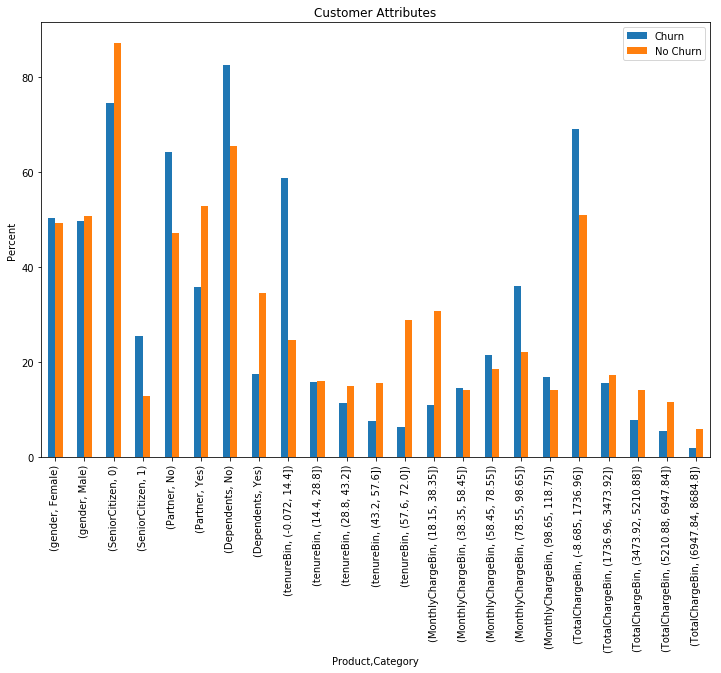

In [13]:
eda_cat_barchart(df, cols, title='Customer Attributes')

There is little difference in gender of churned versus non-churned customers. Churned customers are more likely to be senior citizens or single, both categories where customers are less likely to have dependents.

Customers on low cost plans are less likely to churn. Customers in the highest cost plans are also less likely to churn. However, it appears that customers in the 4th quintile, who are paying quite a bit but not the very most, seem more likely to leave. Is there something about the more expensive, but not most expensive, plan that leads customers to feel they are not getting their money's worth? 

It is disconcerting that the customers being lost are 
in the fourth quintile for monthly revenue. These are
some of the more potentially profitable customers who are walking out the door, not the ones who are on the cheap plans.

## Early customers in detail.

The most significant difference in the chart above is by tenure bin: Short tenure customers are disproportionately likely to churn. 
When I auto-binned everything into quintiles, the short-tenure was defined as 0-14 months. Let's break that down some
more and see exactly when the problem occurs.

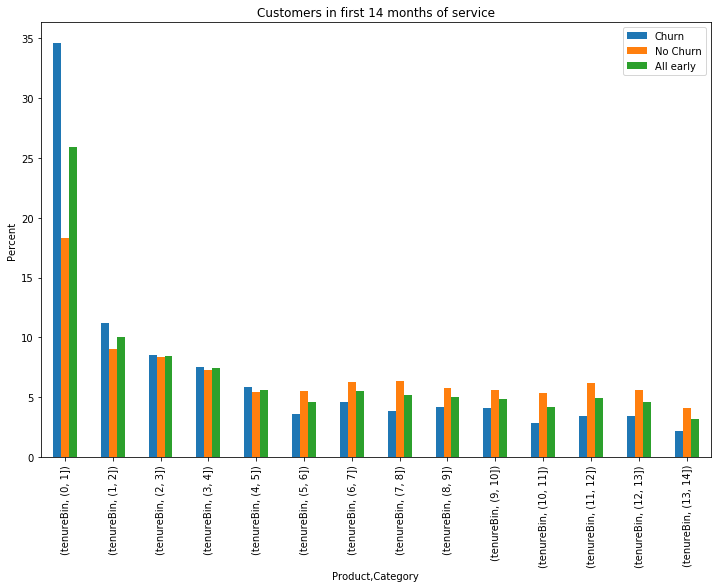

In [14]:
short_tenure = df.query('tenure <= 14').copy()
short_tenure['tenureBin'] = pd.cut(short_tenure.tenure, bins=range(-1, 16))
eda_cat_barchart(short_tenure, ['tenureBin'], title='Customers in first 14 months of service',
                group='All early')

Those churners are in the first month of service -- clearly the company needs to put some focus on the onboarding process of new customers. 

Because the churners are in their very first month of service, we need to be careful about metrics. Paying too
much attention to customer lifetime value (monthly bills times number of months) will miss the segment 
with the worst churn. Aquiring customers is often expensive; aquiring new customers and losing them as soon as they start is a waste of resources.

# Is there anything in the billing columns that stands out? 

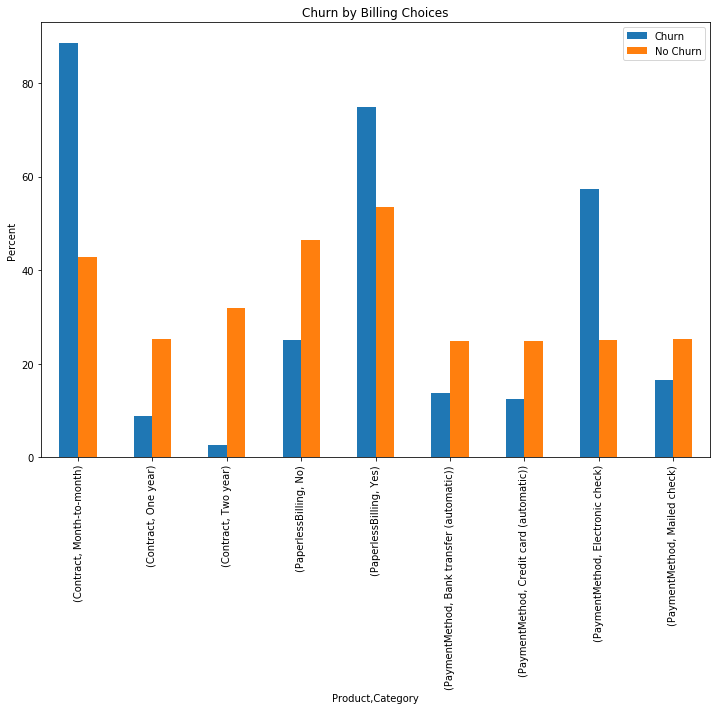

In [15]:
eda_cat_barchart(df, bill_cols, title='Churn by Billing Choices')

Perhaps unsurprisingly, the churned customers are not locked down in a contract. In addition, those who 
are paying by electronic check may be unhappier than those using other payment methods.

Since we know these churners are more likely in the first month of service, it makes sense to look into whether 
customers paying by electronic check have a smooth onboarding process.

# MVP 

An MVP is a minimum viable project: Given what I know so far, what would be my presentation to managment
if I had to stop today? 

We've identified a number of areas of concern here: 
- Internet, and particularly fiber optic internet, customers are more likely to churn
- Customers who did not pay for 'white glove' services (technical support, device protection, 
online security, and online backup) are more likely to churn
- Customers in the fourth quintile of monthly charges
- Customers with one month of service, who are not locked into a one or two year contract
- Customers paying by electronic check

One of the best ways to do customer churn to make sure we're comparing apples-to-apples is to do
cohort analysis. Compare the customers who started at the same time to each other, rather than
customers who have been there for varying amounts of time.

The cohort of interest at this point is customers with one month of service.
Let's take a look at the above features for new customers only.

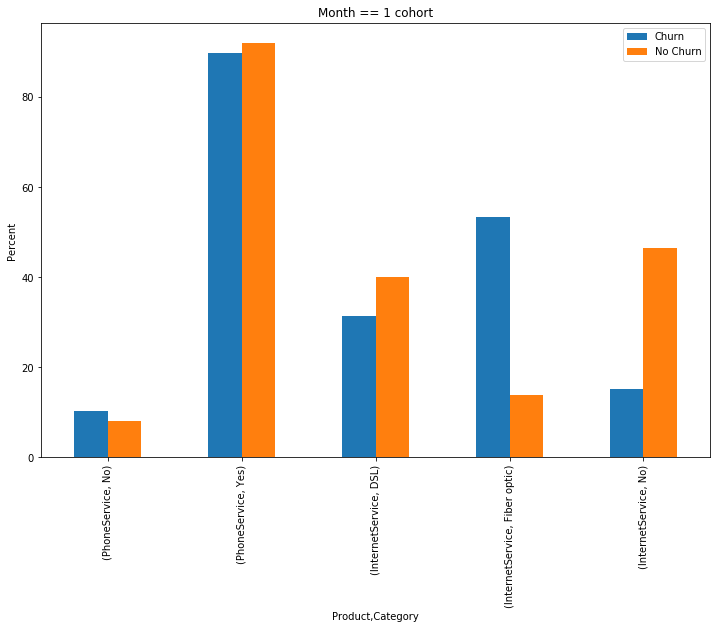

In [16]:
new_customers = df.query('tenure == 1').copy()
eda_cat_barchart(new_customers, ['PhoneService', 'InternetService'],
                title='Month == 1 cohort')

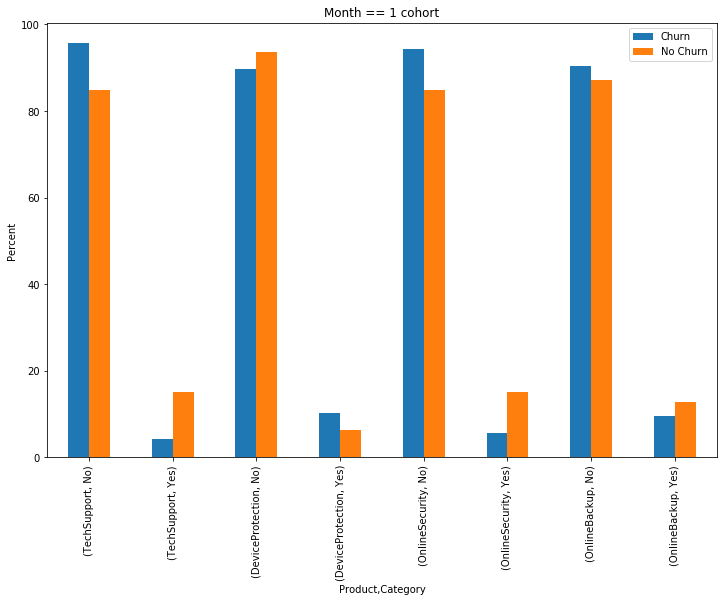

In [17]:
eda_cat_barchart(new_customers.query('InternetService != "No"'), 
                 ['TechSupport', 'DeviceProtection', 'OnlineSecurity', 'OnlineBackup'],
                title='Month == 1 cohort')

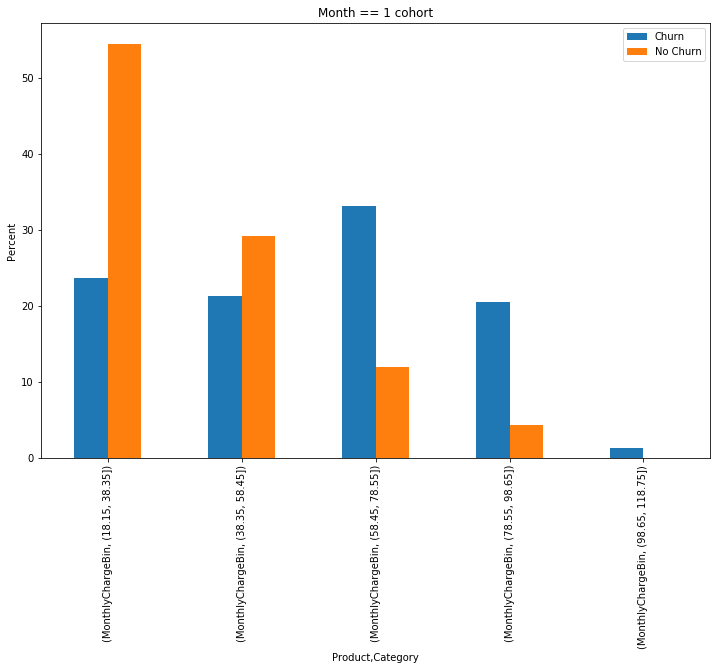

In [18]:
eda_cat_barchart(new_customers, ['MonthlyChargeBin'],  title='Month == 1 cohort')

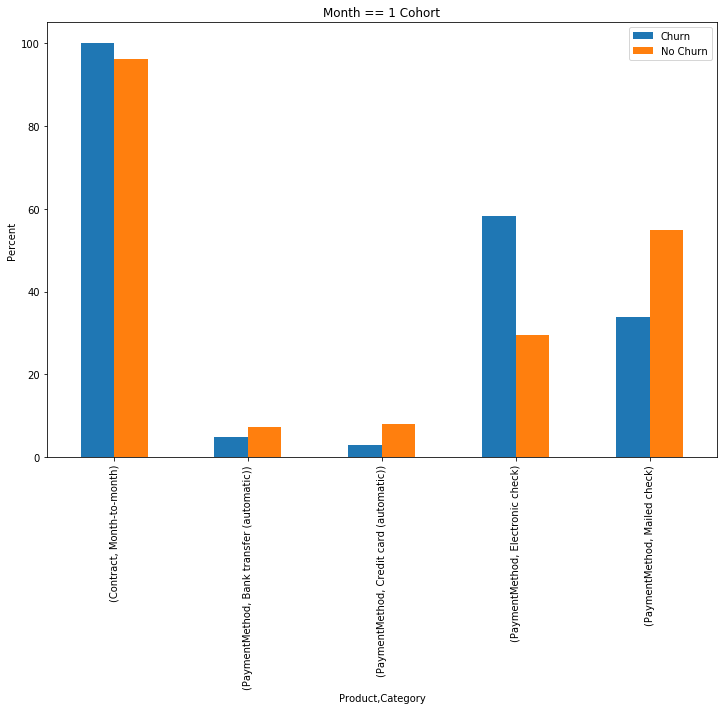

In [19]:
eda_cat_barchart(new_customers,
                 ['Contract', 'PaymentMethod'], 
                 title='Month == 1 Cohort')

With the possible exception of the lack of 'white glove services' issue, all of the potential problem areas 
identified in the general analysis appear in the first-month cohort.

With what I know so far, the first action item for this company should be to ensure that new internet customers, 
particularly those with fiber optic service, are successful and satisfied. Teams focused on 
making these customers happy should prioritize by the monthly payment amount: The more valuable customers are the ones
currently walking out the door, while the less valuable ones are more likely to stay. 
They should also focus on the 
month-to-month customers who have the freedom to walk out the door versus those locked into a contract. 